<a href="https://colab.research.google.com/github/Swelem/obesity_risk/blob/main/lastprojectCORR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import pandas as pd
import numpy as np
import os
import glob
#import optuna
ran_optuna = False
from tqdm import tqdm
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import random
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
#from optuna.samplers import TPESampler

import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader



In [65]:
!pip install -q kaggle

In [66]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saifswelem","key":"93c4723ccbde8c247af262277f428b4b"}'}

In [67]:
!mkdir -p ~/.kaggle

In [68]:

!mkdir /content/Dataset

mkdir: cannot create directory ‘/content/Dataset’: File exists


In [69]:
!cp kaggle.json ~/.kaggle/

In [70]:
! chmod 600 ~/.kaggle/kaggle.json

In [71]:
import os
os.chdir('/content/Dataset')

In [72]:
!kaggle competitions download -c playground-series-s4e2


playground-series-s4e2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [73]:
!unzip playground-series-s4e2.zip

Archive:  playground-series-s4e2.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [74]:
given_test_data = pd.read_csv('/content/Dataset/test.csv')


given_train_data = pd.read_csv('/content/Dataset/train.csv')

In [75]:
given_train_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [76]:
given_test_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [77]:
print(given_train_data.shape)
print(given_test_data.shape)

(20758, 18)
(13840, 17)


In [78]:
print(given_train_data["NObeyesdad"].unique())
class_counts = given_train_data["NObeyesdad"].value_counts()
class_counts

['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

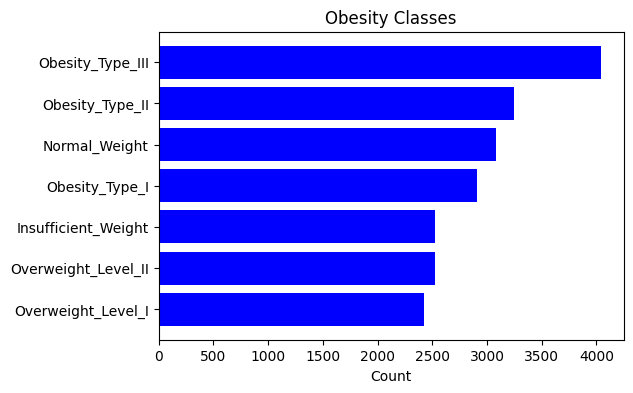

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.barh(class_counts.index, class_counts.values, color="blue")
plt.xlabel("Count")
plt.title("Obesity Classes")
plt.gca().invert_yaxis() ## Invert the y-axis to show the highest frequency class at the top
plt.show()

In [80]:
categorical_features = given_train_data.select_dtypes(include=['object']).columns
continuous_features = given_train_data.select_dtypes(include=['float64','int64']).columns
## Export categorical and continuous data to separate DataFrames

data_cat = given_train_data[categorical_features]
data_cont = given_train_data[continuous_features]
print(data_cat.columns)
print(data_cont.columns)

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')
Index(['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')


In [81]:
data_id= data_cont["id"]
data_cont.drop('id',axis=1, inplace=True)

<ipython-input-81-6bfb34d38753>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cont.drop('id',axis=1, inplace=True)


<ipython-input-82-7f820125f9b5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_cat[col], ax=axes[i], palette='viridis')
<ipython-input-82-7f820125f9b5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_cat[col], ax=axes[i], palette='viridis')
<ipython-input-82-7f820125f9b5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_cat[col], ax=axes[i], palette='viridis')
<ipython-input-82-7f820125f9b5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the

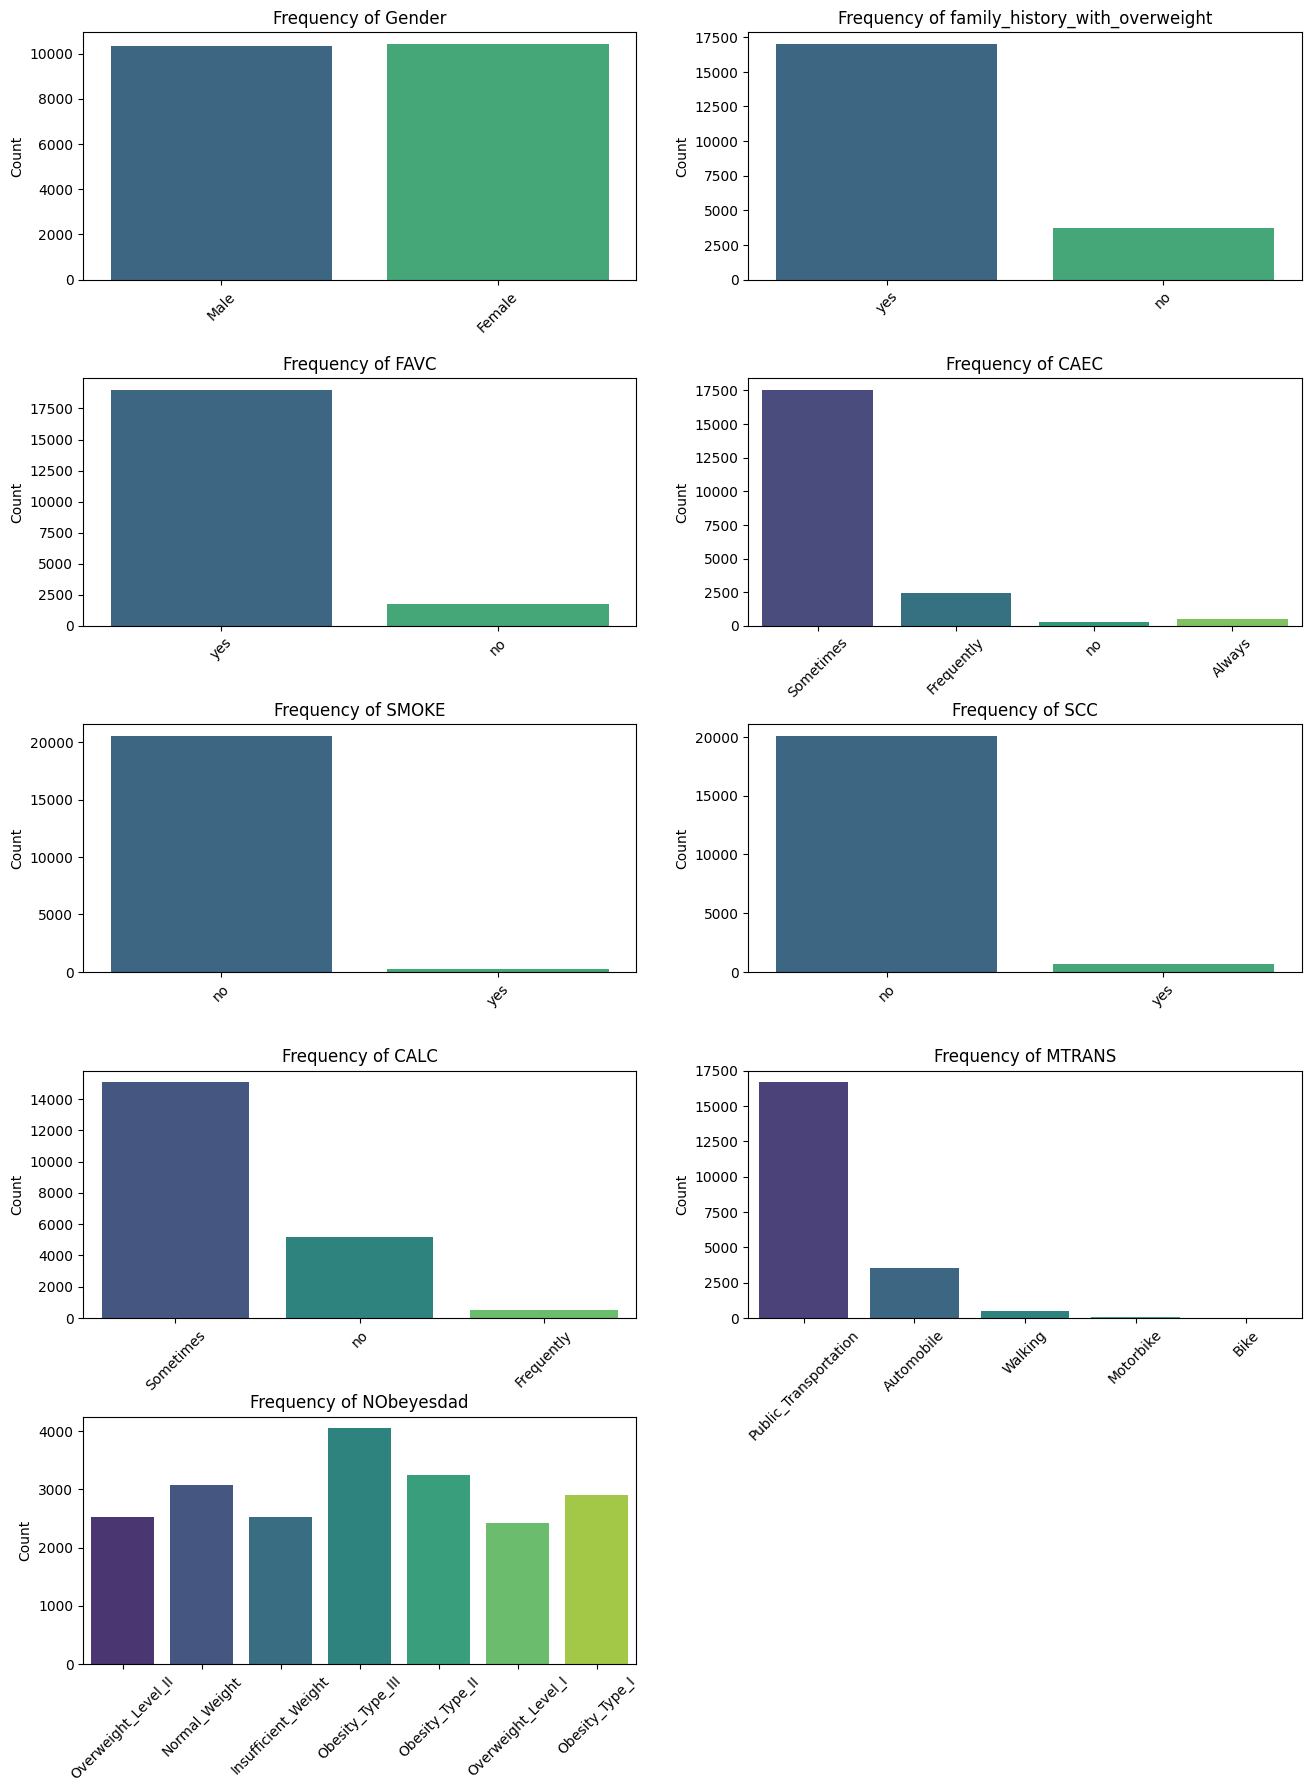

In [82]:
import seaborn as sns

## Drawing a frequency graph for each categorical variable
fig, axes = plt.subplots(nrows=(len(data_cat.columns)+1) // 2, ncols=2,figsize=(14, len(data_cat.columns) * 2))
fig.tight_layout(pad=5.0)

## Adjustment for proper positioning of the axes
axes = axes.ravel()

for i, col in enumerate(data_cat.columns):
    sns.countplot(x=data_cat[col], ax=axes[i], palette='viridis')
    axes[i].set_title(f'Frequency of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

## Closing extra created axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()

In [105]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [106]:
# Add BMI column
df_train['BMI'] = df_train['Weight'] / (df_train['Height']) ** 2
df_test['BMI'] = df_test['Weight'] / (df_test['Height']) ** 2

In [107]:
# Check for missing values
print(df_train.isnull().sum())

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
BMI                               0
dtype: int64


In [108]:
# Define function to round column
def round_column(df: pd.DataFrame,
                 column: str,
                 n_decimals: int = 0) -> pd.DataFrame:

    df[column] = df[column].round(n_decimals)
    return df

# Round columns 'FCVC' and 'NCP' to 1 decimal
df_train = round_column(df_train, 'FCVC')
df_train = round_column(df_train, 'NCP')
df_test = round_column(df_test, 'FCVC')
df_test = round_column(df_test, 'NCP')

# print unique values of 'FCVC' and 'NCP' for train dataset
print(f'{np.unique(df_train["FCVC"]) = }')
print(f'{np.unique(df_train["NCP"]) = }')

# print unique values of 'FCVC' and 'NCP' for test dataset
print(f'{np.unique(df_test["FCVC"]) = }')
print(f'{np.unique(df_test["NCP"]) = }')

np.unique(df_train["FCVC"]) = array([1., 2., 3.])
np.unique(df_train["NCP"]) = array([1., 2., 3., 4.])
np.unique(df_test["FCVC"]) = array([1., 2., 3.])
np.unique(df_test["NCP"]) = array([1., 2., 3., 4.])


In [109]:
# convert Gender to binary
df_train['Gender'] = df_train['Gender'].map({'Male': 1, 'Female': 0})
df_test['Gender'] = df_test['Gender'].map({'Male': 1, 'Female': 0})

# convert age to categorical
age_mapping = {'0-18': 0, '18-30': 1, '30-40': 2, '40-50': 3, '50-60': 4, '60-70': 5, '70-80': 6}
df_train['Age'] = df_train['Age'].map(age_mapping)
df_test['Age'] = df_train['Age'].map(age_mapping)

df_train['Age'] = pd.cut(df_train['Age'], bins=[0, 18, 30, 40, 50, 60, 70, 80], labels=['0-18', '18-30', '30-40', '40-50', '50-60', '60-70', '70-80'])
df_test['Age'] = pd.cut(df_test['Age'], bins=[0, 18, 30, 40, 50, 60, 70, 80], labels=['0-18', '18-30', '30-40', '40-50', '50-60', '60-70', '70-80'])

# convert BMI to categorical
df_train['BMI'] = pd.to_numeric(df_train['BMI'], errors='coerce')
df_test['BMI'] = pd.to_numeric(df_train['BMI'], errors='coerce')

df_train['BMI'] = pd.cut(df_train['BMI'], bins=[0, 18.5, 25, 30, 35, 40, 60], labels=['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III'])
df_test['BMI'] = pd.cut(df_test['BMI'], bins=[0, 18.5, 25, 30, 35, 40, 60], labels=['Underweight', 'Normal', 'Overweight', 'Obesity I', 'Obesity II', 'Obesity III'])

# convert family_history_with_overweight to binary (yes=1, no=0)
df_train['family_history_with_overweight'] = df_train['family_history_with_overweight'].map({'yes': 1, 'no': 0})
df_test['family_history_with_overweight'] = df_test['family_history_with_overweight'].map({'yes': 1, 'no': 0})

# convert SMOKE to binary (yes=1, no=0)
df_train['SMOKE'] = df_train['SMOKE'].map({'yes': 1, 'no': 0})
df_test['SMOKE'] = df_test['SMOKE'].map({'yes': 1, 'no': 0})

# convert SCC to binary (yes=1, no=0)
df_train['SCC'] = df_train['SCC'].map({'yes': 1, 'no': 0})
df_test['SCC'] = df_test['SCC'].map({'yes': 1, 'no': 0})

# convert FAVC to binary (yes=1, no=0)
df_train['FAVC'] = df_train['FAVC'].map({'yes': 1, 'no': 0})
df_test['FAVC'] = df_test['FAVC'].map({'yes': 1, 'no': 0})

# convert CALC to binary (always=3, frequently=2, sometimes=1, no=0)
df_train['CALC'] = df_train['CALC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0})
df_test['CALC'] = df_test['CALC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0})

# convert CAEC to binary (no=0, Sometimes=1, Frequently=2, Always=3)
df_train['CAEC'] = df_train['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
df_test['CAEC'] = df_test['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})

# convert MTRANS to dummy variables with fusioning motobike and bike into automobile
df_train = pd.get_dummies(df_train, columns=['MTRANS'])
df_test = pd.get_dummies(df_test, columns=['MTRANS'])

# round CH2O to 0 decimals
df_train = round_column(df_train, 'CH2O')
df_test = round_column(df_test, 'CH2O')

# round TUE to 1 decimal
df_train = round_column(df_train, 'TUE', n_decimals=1)
df_test = round_column(df_test, 'TUE', n_decimals=1)

# round FAF to 1 decimal
df_train = round_column(df_train, 'FAF', n_decimals=1)
df_test = round_column(df_test, 'FAF', n_decimals=1)

# Put BMI and Age to numerical values
df_train['BMI'] = df_train['BMI'].cat.codes
df_train['Age'] = df_train['Age'].cat.codes
df_test['BMI'] = df_test['BMI'].cat.codes
df_test['Age'] = df_test['Age'].cat.codes

# delete height and weight columns
# df_train = df_train.drop(['Height', 'Weight'], axis=1)
# df_test = df_test.drop(['Height', 'Weight'], axis=1)

# Add polynomial features
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
X_polynomial = polynomial_features.fit_transform(df_train[['Age', 'BMI']])
df_train.drop(['Age', 'BMI'], axis=1, inplace=True)
df_train = pd.concat([df_train, pd.DataFrame(X_polynomial, columns=['Age', 'BMI', 'Age^2', 'Age*BMI', 'BMI^2'])], axis=1)
X_polynomial2 = polynomial_features.fit_transform(df_train[['Weight', 'Height']])
df_train.drop(['Weight', 'Height'], axis=1, inplace=True)
df_train = pd.concat([df_train, pd.DataFrame(X_polynomial2, columns=['Weight', 'Height', 'Weight^2', 'Weight*Height', 'Height^2'])], axis=1)

X_polynomial = polynomial_features.fit_transform(df_test[['Age', 'BMI']])
df_test.drop(['Age', 'BMI'], axis=1, inplace=True)
df_test = pd.concat([df_test, pd.DataFrame(X_polynomial, columns=['Age', 'BMI', 'Age^2', 'Age*BMI', 'BMI^2'])], axis=1)
X_polynomial2 = polynomial_features.fit_transform(df_test[['Weight', 'Height']])
df_test.drop(['Weight', 'Height'], axis=1, inplace=True)
df_test = pd.concat([df_test, pd.DataFrame(X_polynomial2, columns=['Weight', 'Height', 'Weight^2', 'Weight*Height', 'Height^2'])], axis=1)

In [110]:
print(df_train['Age'].dtype)

float64


In [111]:
print(df_train['BMI'].dtype)


float64


In [112]:
# convert NObeyesdad to numerical values
df_train['NObeyesdad'] = df_train['NObeyesdad'].map({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})

In [126]:
df_train2 = df_train
df_train2['NObeyesdad']

0        3
1        1
2        0
3        6
4        3
        ..
28317    5
28318    5
28319    5
28320    5
28321    5
Name: NObeyesdad, Length: 28322, dtype: int64

In [118]:
# Apply SMOTE to balance the dataset
X_train = df_train.drop(columns=['NObeyesdad'])
y_train = df_train['NObeyesdad']

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Create a new dataframe with the balanced dataset
df_train = pd.concat([X_train, y_train], axis=1)

In [119]:
X = df_train.drop(['NObeyesdad', 'id'], axis=1)
y = df_train['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42, max_depth=20, n_estimators=800, criterion='gini')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
#ax = plt.subplot(1, 1, 1)
#_ = utilities.plot_confusion_matrix_heatmap(ax, y_test, y_pred)
#from sklearn.metrics import plot_confusion_matrix

# Plot confusion matrix
#plt.figure(figsize=(10, 7))
#plot_confusion_matrix(rf, X_test, y_test, ax=plt.gca(), cmap=plt.cm.Blues, values_format='.0f')
#plt.show()


              precision    recall  f1-score   support

           0       0.93      0.94      0.94       809
           1       0.86      0.87      0.86       841
           2       0.82      0.79      0.80       829
           3       0.80      0.84      0.82       801
           4       0.89      0.86      0.87       818
           5       0.96      0.96      0.96       806
           6       1.00      1.00      1.00       761

    accuracy                           0.89      5665
   macro avg       0.89      0.89      0.89      5665
weighted avg       0.89      0.89      0.89      5665



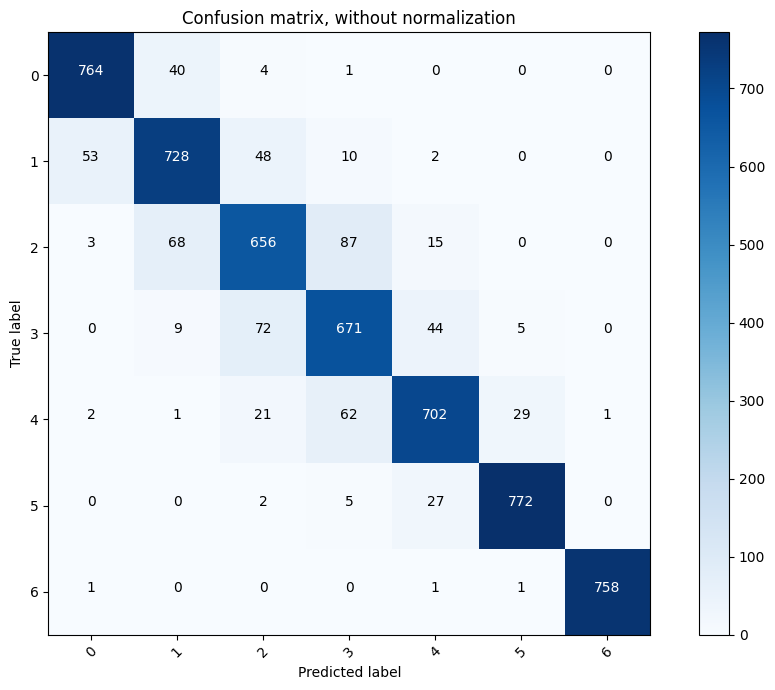

In [94]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix manually
def compute_confusion_matrix(y_true, y_pred, classes):
    num_classes = len(classes)
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        cm[true_label, pred_label] += 1
    return cm

# Assuming you have defined rf.classes_ as the list of class labels in your RandomForestClassifier
classes = rf.classes_

# Assuming you have computed y_pred using your RandomForestClassifier
cm = compute_confusion_matrix(y_test, y_pred, classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
plot_confusion_matrix(cm, classes=classes)
plt.show()


              precision    recall  f1-score   support

           0       0.93      0.95      0.94       809
           1       0.87      0.88      0.87       841
           2       0.83      0.81      0.82       829
           3       0.81      0.85      0.83       801
           4       0.90      0.87      0.88       818
           5       0.96      0.97      0.96       806
           6       1.00      1.00      1.00       761

    accuracy                           0.90      5665
   macro avg       0.90      0.90      0.90      5665
weighted avg       0.90      0.90      0.90      5665



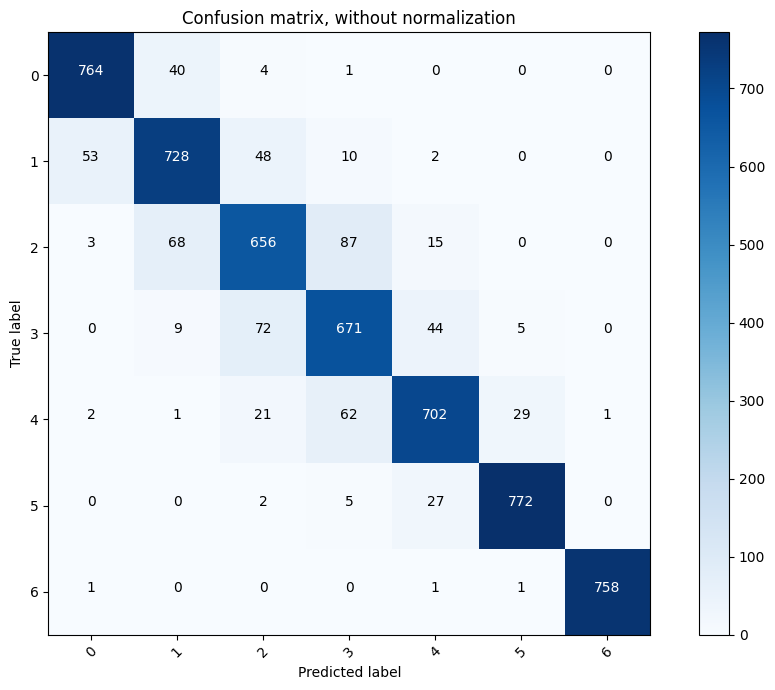

In [95]:
# Xgboost
from xgboost import XGBClassifier

best_params = {
    'grow_policy': 'depthwise',
    'n_estimators': 1318,
    'learning_rate': 0.06854096966928382,
    'gamma': 0.6829197356513476,
    'subsample': 0.8942042552212566,
    'colsample_bytree': 0.32036152443164206,
    'max_depth': 18,
    'min_child_weight': 10,
    'reg_lambda': 4.33935436979607e-05,
    'reg_alpha': 0.00014155585622193723
}
best_params['booster'] = 'gbtree'
best_params['objective'] = 'multi:softmax'
best_params["verbosity"] = 0

xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
#plt.figure(figsize=(10, 7))
#ax = plt.subplot(1, 1, 1)
#_ = utilities.plot_confusion_matrix_heatmap(ax, y_test, y_pred, cmap='Reds')
plt.figure(figsize=(10, 7))
plot_confusion_matrix(cm, classes=xgb.classes_)
plt.show()


In [96]:
import lightgbm as lgb
def optim_lgb(trial):
    lgbParams = {
        'num_class': 7,
        'random_state': 42,
        'metric': 'multi_logloss',
        "boosting_type": "gbdt",
        'objective': 'multiclass',

        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-1, 10.0),
        'max_depth': trial.suggest_int('max_depth', 6, 20),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
    }

    lgb_model=lgb.LGBMClassifier(**lgbParams)

    lgb_model.fit(X_train,y_train)

    y_pred = lgb_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    return acc

In [97]:
if ran_optuna:
    print('Number of finished trials: {}'.format(len(study.trials)))

    print(f'Best trial: {study.best_trial.params}')

    optuna.visualization.plot_optimization_history(study)

    study.trials_dataframe().sort_values('value', ascending=False)

    optuna.visualization.plot_slice(study)

else:
    # Moaz HyperParams
    lgbParams = {
        "objective": "multiclass",          # Objective function for the model
        "metric": "multi_logloss",          # Evaluation metric
        "verbosity": -1,                    # Verbosity level (-1 for silent)
        "boosting_type": "gbdt",            # Gradient boosting type
        "random_state": 42,       # Random state for reproducibility
        "num_class": 7,                     # Number of classes in the dataset
        'learning_rate': 0.030962211546832760,  # Learning rate for gradient boosting
        'n_estimators': 500,                # Number of boosting iterations
        'lambda_l1': 0.009667446568254372,  # L1 regularization term
        'lambda_l2': 0.04018641437301800,   # L2 regularization term
        'max_depth': 10,                    # Maximum depth of the trees
        'colsample_bytree': 0.40977129346872643,  # Fraction of features to consider for each tree
        'subsample': 0.9535797422450176,    # Fraction of samples to consider for each boosting iteration
        'min_child_samples': 26,            # Minimum number of data needed in a leaf
        'boosting_type': 'gbdt',
        'num_class': 7,
        'random_state': 42,
        'metric': 'multi_logloss',
    }

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       809
           1       0.87      0.87      0.87       841
           2       0.83      0.82      0.82       829
           3       0.82      0.85      0.84       801
           4       0.90      0.87      0.89       818
           5       0.96      0.97      0.96       806
           6       1.00      1.00      1.00       761

    accuracy                           0.90      5665
   macro avg       0.90      0.90      0.90      5665
weighted avg       0.90      0.90      0.90      5665



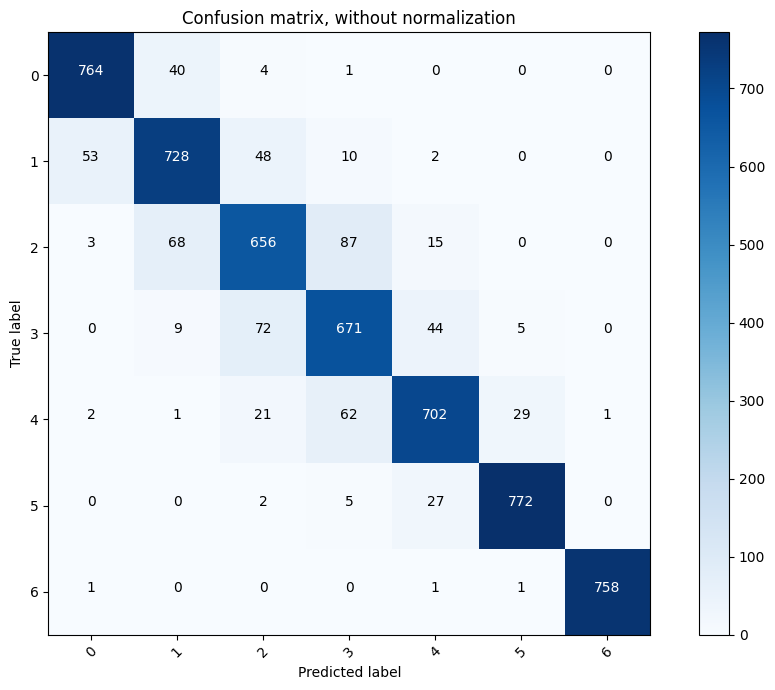

In [98]:
lgb_model_final = lgb.LGBMClassifier(**lgbParams)
lgb_model_final.fit(X_train, y_train)

y_pred = lgb_model_final.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
# plt.figure(figsize=(10, 7))
# ax = plt.subplot(1, 1, 1)
# utilities.plot_confusion_matrix_heatmap(ax, y_test, y_pred, cmap='Greens')
plt.figure(figsize=(10, 7))
plot_confusion_matrix(cm, classes=lgb_model_final.classes_)
plt.show()

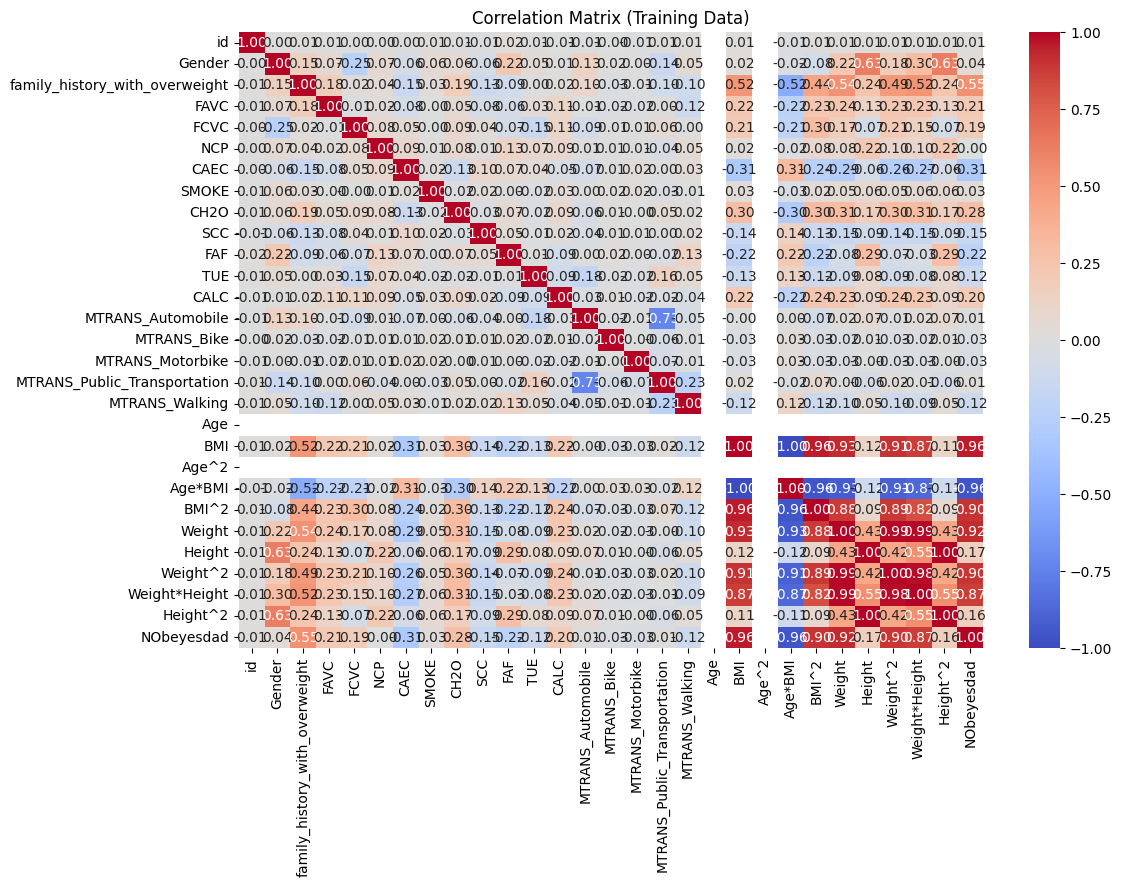

Features with strong negative correlations in training data:
id and SCC: -0.01
id and CALC: -0.01
id and MTRANS_Automobile: -0.01
id and MTRANS_Bike: -0.00
id and MTRANS_Motorbike: -0.01
id and Age*BMI: -0.01
Gender and FCVC: -0.25
Gender and CAEC: -0.06
Gender and SCC: -0.06
Gender and MTRANS_Public_Transportation: -0.14
Gender and Age*BMI: -0.02
Gender and BMI^2: -0.08
family_history_with_overweight and CAEC: -0.15
family_history_with_overweight and SCC: -0.13
family_history_with_overweight and FAF: -0.09
family_history_with_overweight and MTRANS_Bike: -0.03
family_history_with_overweight and MTRANS_Motorbike: -0.01
family_history_with_overweight and MTRANS_Public_Transportation: -0.10
family_history_with_overweight and MTRANS_Walking: -0.10
family_history_with_overweight and Age*BMI: -0.52
FAVC and FCVC: -0.01
FAVC and CAEC: -0.08
FAVC and SMOKE: -0.00
FAVC and SCC: -0.08
FAVC and FAF: -0.06
FAVC and MTRANS_Automobile: -0.01
FAVC and MTRANS_Bike: -0.02
FAVC and MTRANS_Motorbike: -0.

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Step 1: Load training and testing data
# Assuming you have loaded training and testing data into DataFrames df_train and df_test

# Step 2: Visualize correlation and drop features in df_train
correlation_matrix_train = df_train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_train, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Training Data)")
plt.show()

# Identify features with strong negative correlations in df_train
neg_corr_features_train = correlation_matrix_train[correlation_matrix_train < 0].stack().dropna().index.tolist()

# Print features with strong negative correlations in df_train
if neg_corr_features_train:
    print("Features with strong negative correlations in training data:")
    for feature_pair in neg_corr_features_train:
        feature1, feature2 = feature_pair
        correlation = correlation_matrix_train.loc[feature1, feature2]
        print(f"{feature1} and {feature2}: {correlation:.2f}")
else:
    print("No features have strong negative correlations in training data.")






Features with strong negative correlations in training data:
family_history_with_overweight and Age*BMI: -0.52
MTRANS_Automobile and MTRANS_Public_Transportation: -0.73
MTRANS_Public_Transportation and MTRANS_Automobile: -0.73
BMI and Age*BMI: -1.00
Age*BMI and family_history_with_overweight: -0.52
Age*BMI and BMI: -1.00
Age*BMI and BMI^2: -0.96
Age*BMI and Weight: -0.93
Age*BMI and Weight^2: -0.91
Age*BMI and Weight*Height: -0.87
Age*BMI and NObeyesdad: -0.96
BMI^2 and Age*BMI: -0.96
Weight and Age*BMI: -0.93
Weight^2 and Age*BMI: -0.91
Weight*Height and Age*BMI: -0.87
NObeyesdad and Age*BMI: -0.96


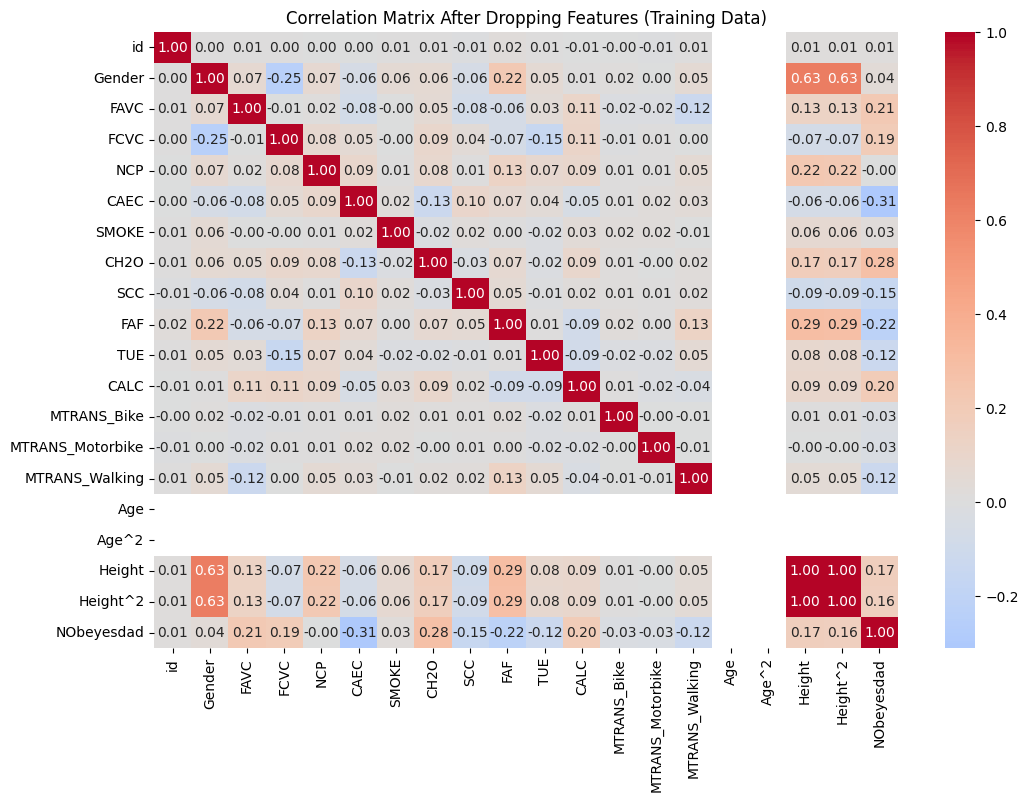

Dropped features: ['family_history_with_overweight', 'Age*BMI', 'MTRANS_Automobile', 'MTRANS_Public_Transportation', 'BMI', 'BMI^2', 'Weight', 'Weight^2', 'Weight*Height']


In [127]:
# Make a copy of df_train to keep the original data intact
df_train_copy = df_train.copy()

# Set correlation threshold for dropping features
corr_threshold = -0.5  # Adjust as needed

# Identify features with strong negative correlations in df_train_copy
neg_corr_features_train = correlation_matrix_train[correlation_matrix_train < corr_threshold].stack().dropna().index.tolist()

# Drop features with strong negative correlations from df_train_copy
dropped_features = []
if neg_corr_features_train:
    print("Features with strong negative correlations in training data:")
    for feature_pair in neg_corr_features_train:
        feature1, feature2 = feature_pair
        correlation = correlation_matrix_train.loc[feature1, feature2]
        print(f"{feature1} and {feature2}: {correlation:.2f}")
        # Check if the columns exist before dropping them and ensure not to drop the target column
        if feature1 in df_train2.columns and feature1 != 'NObeyesdad':
            df_train2.drop(columns=[feature1], inplace=True)
            dropped_features.append(feature1)
        if feature2 in df_train2.columns and feature2 != 'NObeyesdad':
            df_train2.drop(columns=[feature2], inplace=True)
            dropped_features.append(feature2)
else:
    print("No features have strong negative correlations in training data.")

# Visualize the correlation matrix after dropping features
plt.figure(figsize=(12, 8))
sns.heatmap(df_train2.corr(), annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Matrix After Dropping Features (Training Data)")
plt.show()

# Print the dropped features
print("Dropped features:", dropped_features)


In [132]:
df_train2['NObeyesdad']

0        3
1        1
2        0
3        6
4        3
        ..
28317    5
28318    5
28319    5
28320    5
28321    5
Name: NObeyesdad, Length: 28322, dtype: int64

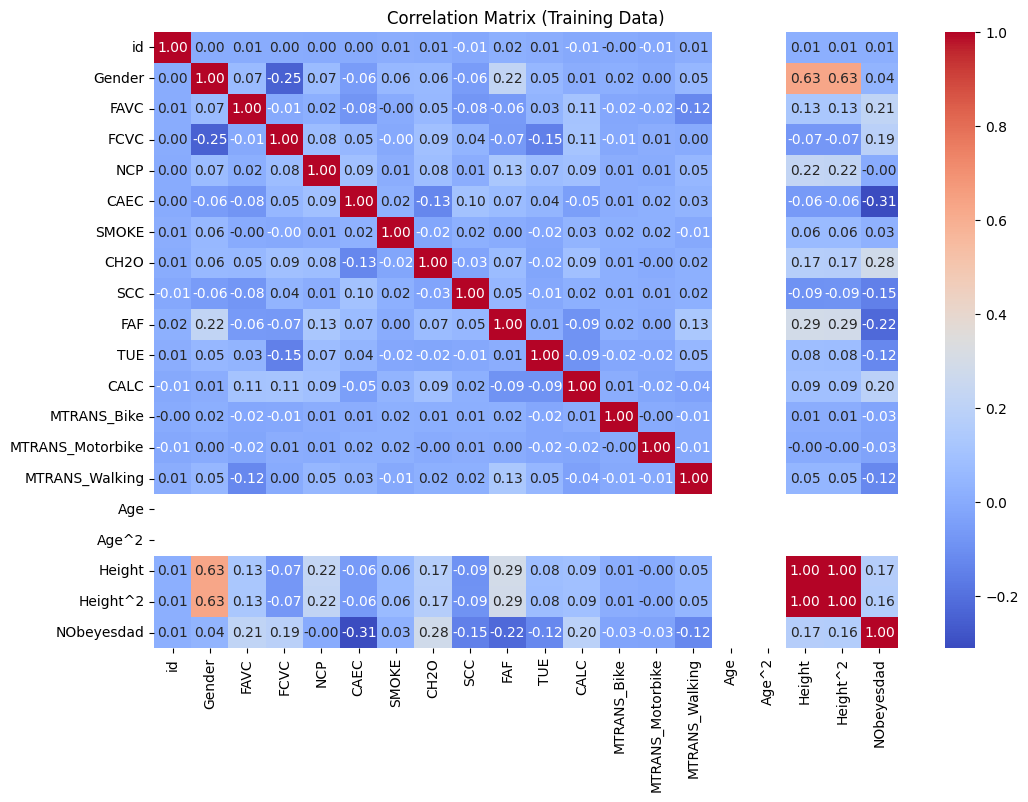

Features with strong negative correlations in training data:
id and SCC: -0.01
id and CALC: -0.01
id and MTRANS_Bike: -0.00
id and MTRANS_Motorbike: -0.01
Gender and FCVC: -0.25
Gender and CAEC: -0.06
Gender and SCC: -0.06
FAVC and FCVC: -0.01
FAVC and CAEC: -0.08
FAVC and SMOKE: -0.00
FAVC and SCC: -0.08
FAVC and FAF: -0.06
FAVC and MTRANS_Bike: -0.02
FAVC and MTRANS_Motorbike: -0.02
FAVC and MTRANS_Walking: -0.12
FCVC and Gender: -0.25
FCVC and FAVC: -0.01
FCVC and SMOKE: -0.00
FCVC and FAF: -0.07
FCVC and TUE: -0.15
FCVC and MTRANS_Bike: -0.01
FCVC and Height: -0.07
FCVC and Height^2: -0.07
NCP and NObeyesdad: -0.00
CAEC and Gender: -0.06
CAEC and FAVC: -0.08
CAEC and CH2O: -0.13
CAEC and CALC: -0.05
CAEC and Height: -0.06
CAEC and Height^2: -0.06
CAEC and NObeyesdad: -0.31
SMOKE and FAVC: -0.00
SMOKE and FCVC: -0.00
SMOKE and CH2O: -0.02
SMOKE and TUE: -0.02
SMOKE and MTRANS_Walking: -0.01
CH2O and CAEC: -0.13
CH2O and SMOKE: -0.02
CH2O and SCC: -0.03
CH2O and TUE: -0.02
CH2O and M

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Step 1: Load training and testing data
# Assuming you have loaded training and testing data into DataFrames df_train and df_test

# Step 2: Visualize correlation and drop features in df_train
correlation_matrix_train = df_train2.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_train, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Training Data)")
plt.show()

# Identify features with strong negative correlations in df_train
neg_corr_features_train = correlation_matrix_train[correlation_matrix_train < 0].stack().dropna().index.tolist()

# Print features with strong negative correlations in df_train
if neg_corr_features_train:
    print("Features with strong negative correlations in training data:")
    for feature_pair in neg_corr_features_train:
        feature1, feature2 = feature_pair
        correlation = correlation_matrix_train.loc[feature1, feature2]
        print(f"{feature1} and {feature2}: {correlation:.2f}")
else:
    print("No features have strong negative correlations in training data.")






              precision    recall  f1-score   support

           0       0.73      0.73      0.73       809
           1       0.58      0.61      0.60       841
           2       0.57      0.45      0.51       829
           3       0.57      0.55      0.56       801
           4       0.62      0.61      0.61       818
           5       0.76      0.90      0.83       806
           6       0.98      0.99      0.98       761

    accuracy                           0.69      5665
   macro avg       0.69      0.69      0.69      5665
weighted avg       0.68      0.69      0.69      5665



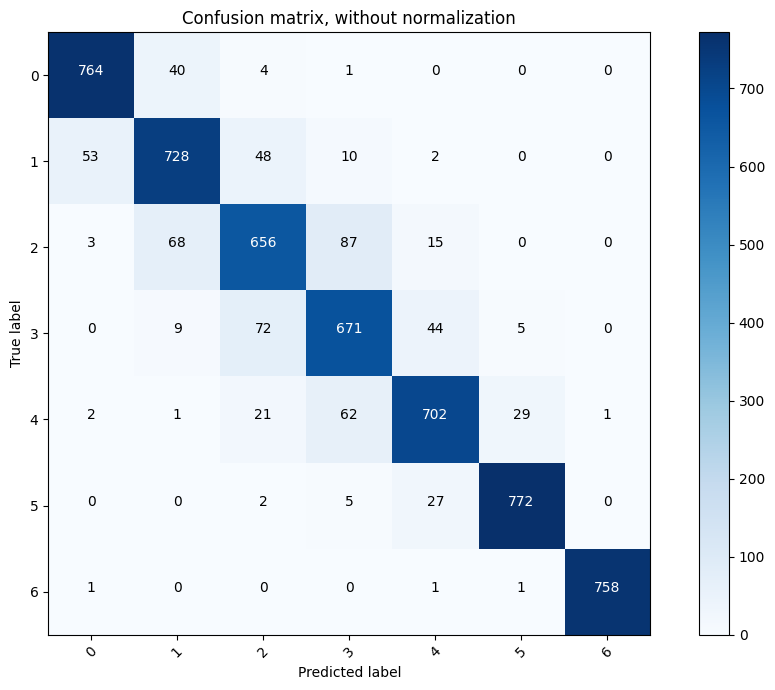

In [129]:
# Apply SMOTE to balance the dataset
X_train = df_train2.drop(columns=['NObeyesdad'])
y_train = df_train2['NObeyesdad']

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Create a new dataframe with the balanced dataset
df_train2 = pd.concat([X_train, y_train], axis=1)
X = df_train2.drop(['NObeyesdad', 'id'], axis=1)
y = df_train2['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Xgboost
from xgboost import XGBClassifier

best_params = {
    'grow_policy': 'depthwise',
    'n_estimators': 1318,
    'learning_rate': 0.06854096966928382,
    'gamma': 0.6829197356513476,
    'subsample': 0.8942042552212566,
    'colsample_bytree': 0.32036152443164206,
    'max_depth': 18,
    'min_child_weight': 10,
    'reg_lambda': 4.33935436979607e-05,
    'reg_alpha': 0.00014155585622193723
}
best_params['booster'] = 'gbtree'
best_params['objective'] = 'multi:softmax'
best_params["verbosity"] = 0

xgb = XGBClassifier(**best_params)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
#plt.figure(figsize=(10, 7))
#ax = plt.subplot(1, 1, 1)
#_ = utilities.plot_confusion_matrix_heatmap(ax, y_test, y_pred, cmap='Reds')
plt.figure(figsize=(10, 7))
plot_confusion_matrix(cm, classes=xgb.classes_)
plt.show()


              precision    recall  f1-score   support

           0       0.70      0.70      0.70       809
           1       0.53      0.51      0.52       841
           2       0.55      0.46      0.50       829
           3       0.55      0.56      0.55       801
           4       0.59      0.60      0.59       818
           5       0.75      0.87      0.81       806
           6       0.97      0.99      0.98       761

    accuracy                           0.66      5665
   macro avg       0.66      0.67      0.66      5665
weighted avg       0.66      0.66      0.66      5665



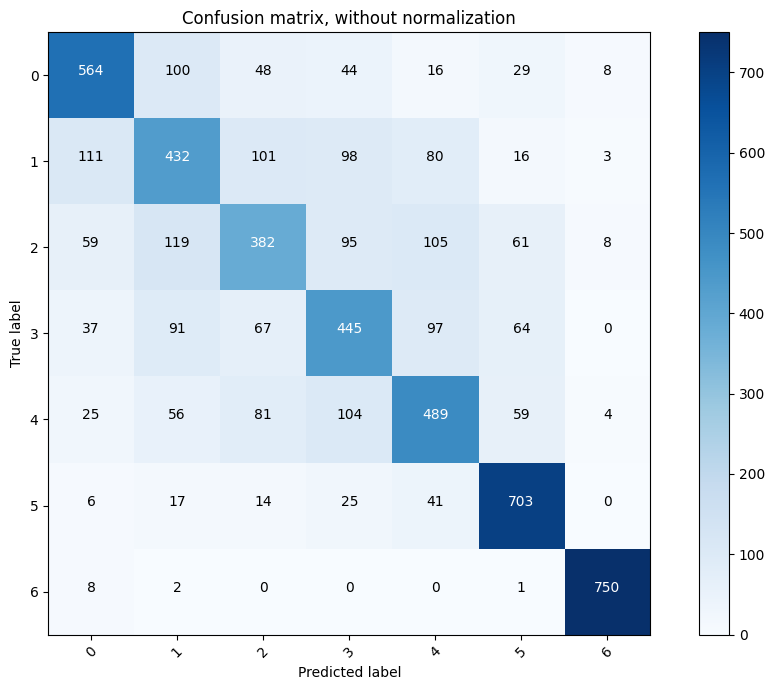

In [130]:
X = df_train.drop(['NObeyesdad', 'id'], axis=1)
y = df_train['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42, max_depth=20, n_estimators=800, criterion='gini')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
#ax = plt.subplot(1, 1, 1)
#_ = utilities.plot_confusion_matrix_heatmap(ax, y_test, y_pred)
#from sklearn.metrics import plot_confusion_matrix

# Plot confusion matrix
#plt.figure(figsize=(10, 7))
#plot_confusion_matrix(rf, X_test, y_test, ax=plt.gca(), cmap=plt.cm.Blues, values_format='.0f')
#plt.show()
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix manually
def compute_confusion_matrix(y_true, y_pred, classes):
    num_classes = len(classes)
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        cm[true_label, pred_label] += 1
    return cm

# Assuming you have defined rf.classes_ as the list of class labels in your RandomForestClassifier
classes = rf.classes_

# Assuming you have computed y_pred using your RandomForestClassifier
cm = compute_confusion_matrix(y_test, y_pred, classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
plot_confusion_matrix(cm, classes=classes)
plt.show()
